<a href="https://colab.research.google.com/github/mmender2/Ai-DataScience/blob/main/mmeGood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-aiplatform --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.4 MB/s eta 0:00:00


In [ ]:
!pip install shuffle --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
import random
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Dropout, LSTM, Bidirectional, Dropout, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import os
from PIL import Image
import requests
import warnings
import re
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# List of US States
us_states = [
    'alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
    'connecticut', 'delaware', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois',
    'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland',
    'massachusetts', 'michigan', 'minnesota', 'mississippi', 'missouri', 'montana',
    'nebraska', 'nevada', 'new hampshire', 'new jersey', 'new mexico', 'new york',
    'north carolina', 'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania',
    'rhode island', 'south carolina', 'south dakota', 'tennessee', 'texas', 'utah',
    'vermont', 'virginia', 'washington', 'washington dc', 'west virginia', 'wisconsin', 'wyoming'
]

In [ ]:
# Create metadata for the images in the provided data path
import random

data_path = '/content/drive/MyDrive/LicensePlate/archive/data'
# List all subdirectories in the data_path directory
all_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# Sort the directories (optional)
all_dirs = sorted(all_dirs)

# Split the directories into groups of three
groups_of_three = [all_dirs[i:i+3] for i in range(0, len(all_dirs), 3)]

def get_first_image_paths(state_dir, num_images=40):
    """Return the first num_images image paths from the state directory."""
    all_images = sorted([img for img in os.listdir(state_dir) if img.endswith('.jpg')])
    return all_images[:num_images]

grouped_paths = []

for group in groups_of_three:
    group_images = []
    for state in group:
        state_dir = os.path.join(data_path, state)
        images = get_first_image_paths(state_dir)
        group_images.extend([os.path.join(state_dir, img) for img in images])
    grouped_paths.append(group_images)


# Get all directories in the data_path

# Randomly select three directories
selected_dirs = random.sample(all_dirs, 3)

def create_metadata_from_image_paths(image_paths):
    labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

    # Create a DataFrame with image paths and their corresponding labels
    meta_data = pd.DataFrame(
        {
            'image_paths': image_paths,
            'labels': labels
        }
    )
    return meta_data

all_metadata = []

for paths in grouped_paths:
    metadata = create_metadata_from_image_paths(paths)
    all_metadata.append(metadata)


In [ ]:
all_metadata[2].head



<bound method NDFrame.head of                                            image_paths       labels
0    /content/drive/MyDrive/LicensePlate/archive/da...  Connecticut
1    /content/drive/MyDrive/LicensePlate/archive/da...  Connecticut
2    /content/drive/MyDrive/LicensePlate/archive/da...  Connecticut
3    /content/drive/MyDrive/LicensePlate/archive/da...  Connecticut
4    /content/drive/MyDrive/LicensePlate/archive/da...  Connecticut
..                                                 ...          ...
115  /content/drive/MyDrive/LicensePlate/archive/da...      Florida
116  /content/drive/MyDrive/LicensePlate/archive/da...      Florida
117  /content/drive/MyDrive/LicensePlate/archive/da...      Florida
118  /content/drive/MyDrive/LicensePlate/archive/da...      Florida
119  /content/drive/MyDrive/LicensePlate/archive/da...      Florida

[120 rows x 2 columns]>

In [ ]:
def process_grouped_images(grouped_paths):
    processed_grouped_images = []

    for paths in grouped_paths:
        processed_images = []
        labels = []

        for path in paths:
            # Extract the associated label from the path
            label_text = os.path.basename(os.path.dirname(path))

            # Read the image in grayscale mode and resize to (512, 512)
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (256, 256))

            if image is None:
                print(f"Failed to read image at path: {path}")
                continue

            # Apply morphological top-hat operation
            structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            imgTopHat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, structuringElement)

            # Apply morphological black-hat operation
            imgBlackHat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, structuringElement)

            # Enhance the image
            imgGrayscalePlusTopHat = cv2.add(image, imgTopHat)
            image = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

            # Apply Gaussian blur
            img_blurred = cv2.GaussianBlur(image, ksize=(5, 5), sigmaX=0)

            # Apply adaptive thresholding
            processed_image = cv2.adaptiveThreshold(
                img_blurred,
                255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY,
                65,
                2
            )

            processed_images.append(processed_image)
            labels.append(label_text)

        processed_grouped_images.append(processed_images)

    return processed_grouped_images

# Process the images
processed_grouped_images = process_grouped_images(grouped_paths)


In [ ]:
import string
# Add lowercase letters to the set of characters and regenerate the mapping
all_characters = sorted(set(string.ascii_uppercase + string.ascii_lowercase + string.digits))

char_to_num = {char: i for i, char in enumerate(all_characters)}
num_to_char = {i: char for char, i in char_to_num.items()}

#num_to_char

In [ ]:
from google.cloud import aiplatform
from google.protobuf import struct_pb2
import base64

class EmbeddingPredictionClient:
    """Wrapper around Prediction Service Client."""
    def __init__(self, project : str,
        location : str = "us-central1",
        api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com"):
        client_options = {"api_endpoint": api_regional_endpoint}
        # Initialize client that will be used to create and send requests.
        # This client only needs to be created once, and can be reused for multiple requests.
        self.client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
        self.location = location
        self.project = project

    def get_embedding(self, text : str = None, image_bytes : bytes = None):
        if not text and not image_bytes:
            raise ValueError('At least one of text or image_bytes must be specified.')

        instance = struct_pb2.Struct()
        if text:
            instance.fields['text'].string_value = text

        if image_bytes:
            encoded_content = base64.b64encode(image_bytes).decode("utf-8")
            image_struct = instance.fields['image'].struct_value
            image_struct.fields['bytesBase64Encoded'].string_value = encoded_content

        instances = [instance]
        endpoint = (f"projects/{self.project}/locations/{self.location}"
            "/publishers/google/models/multimodalembedding@001")
        response = self.client.predict(endpoint=endpoint, instances=instances)

        text_embedding = None
        if text:
            text_emb_value = response.predictions[0]['textEmbedding']
            text_embedding = [v for v in text_emb_value]

        image_embedding = None
        if image_bytes:
            image_emb_value = response.predictions[0]['imageEmbedding']
            image_embedding = [v for v in image_emb_value]

        return {
            'text_embedding': text_embedding,
            'image_embedding': image_embedding
        }


In [ ]:
import cv2

def get_embedding_for_image_np(image_data, text, project):
    """Generate embedding for numpy image array using EmbeddingPredictionClient."""

    # Convert numpy array to bytes for passing to the client
    success, encoded_image = cv2.imencode('.png', image_data)
    image_bytes = encoded_image.tobytes()

    # Initialize the client
    client = EmbeddingPredictionClient(project=project)

    # Fetch the embedding
    response = client.get_embedding(text=text, image_bytes=image_bytes)

    return response

import time

# Assuming processed_images and image_labels are defined and have the same length

all_embeddings = []

# Loop through each group in processed_grouped_images
for group_images in processed_grouped_images:
    group_embeddings = []  # This will store embeddings for each group

    # Loop through each image in the group
    for img_data in group_images:
        # Note: You don't have the state label associated with each image in the provided structure,
        # so I'm using a generic text. You can modify this as required.
        input_text = 'US license plate from one of the states'
        embedding = get_embedding_for_image_np(img_data, input_text, 'fifth-composite-395916')
        group_embeddings.append(embedding)

    all_embeddings.append(group_embeddings)

In [ ]:
import json

# Save the embeddings to a JSON file
with open('embeddings_output.json', 'w') as file:
    json.dump(all_embeddings, file)


In [ ]:
with open('embeddings_output.json', 'r') as file:
    embeddings_data = json.load(file)

all_text_embeddings = []
all_image_embeddings = []
all_embeddings_place = []

for group in embeddings_data:
    for embedding in group:
        all_text_embeddings.append(embedding['text_embedding'])
        all_image_embeddings.append(embedding['image_embedding'])
        all_embeddings_place.append(embedding['text_embedding'] + embedding['image_embedding'])


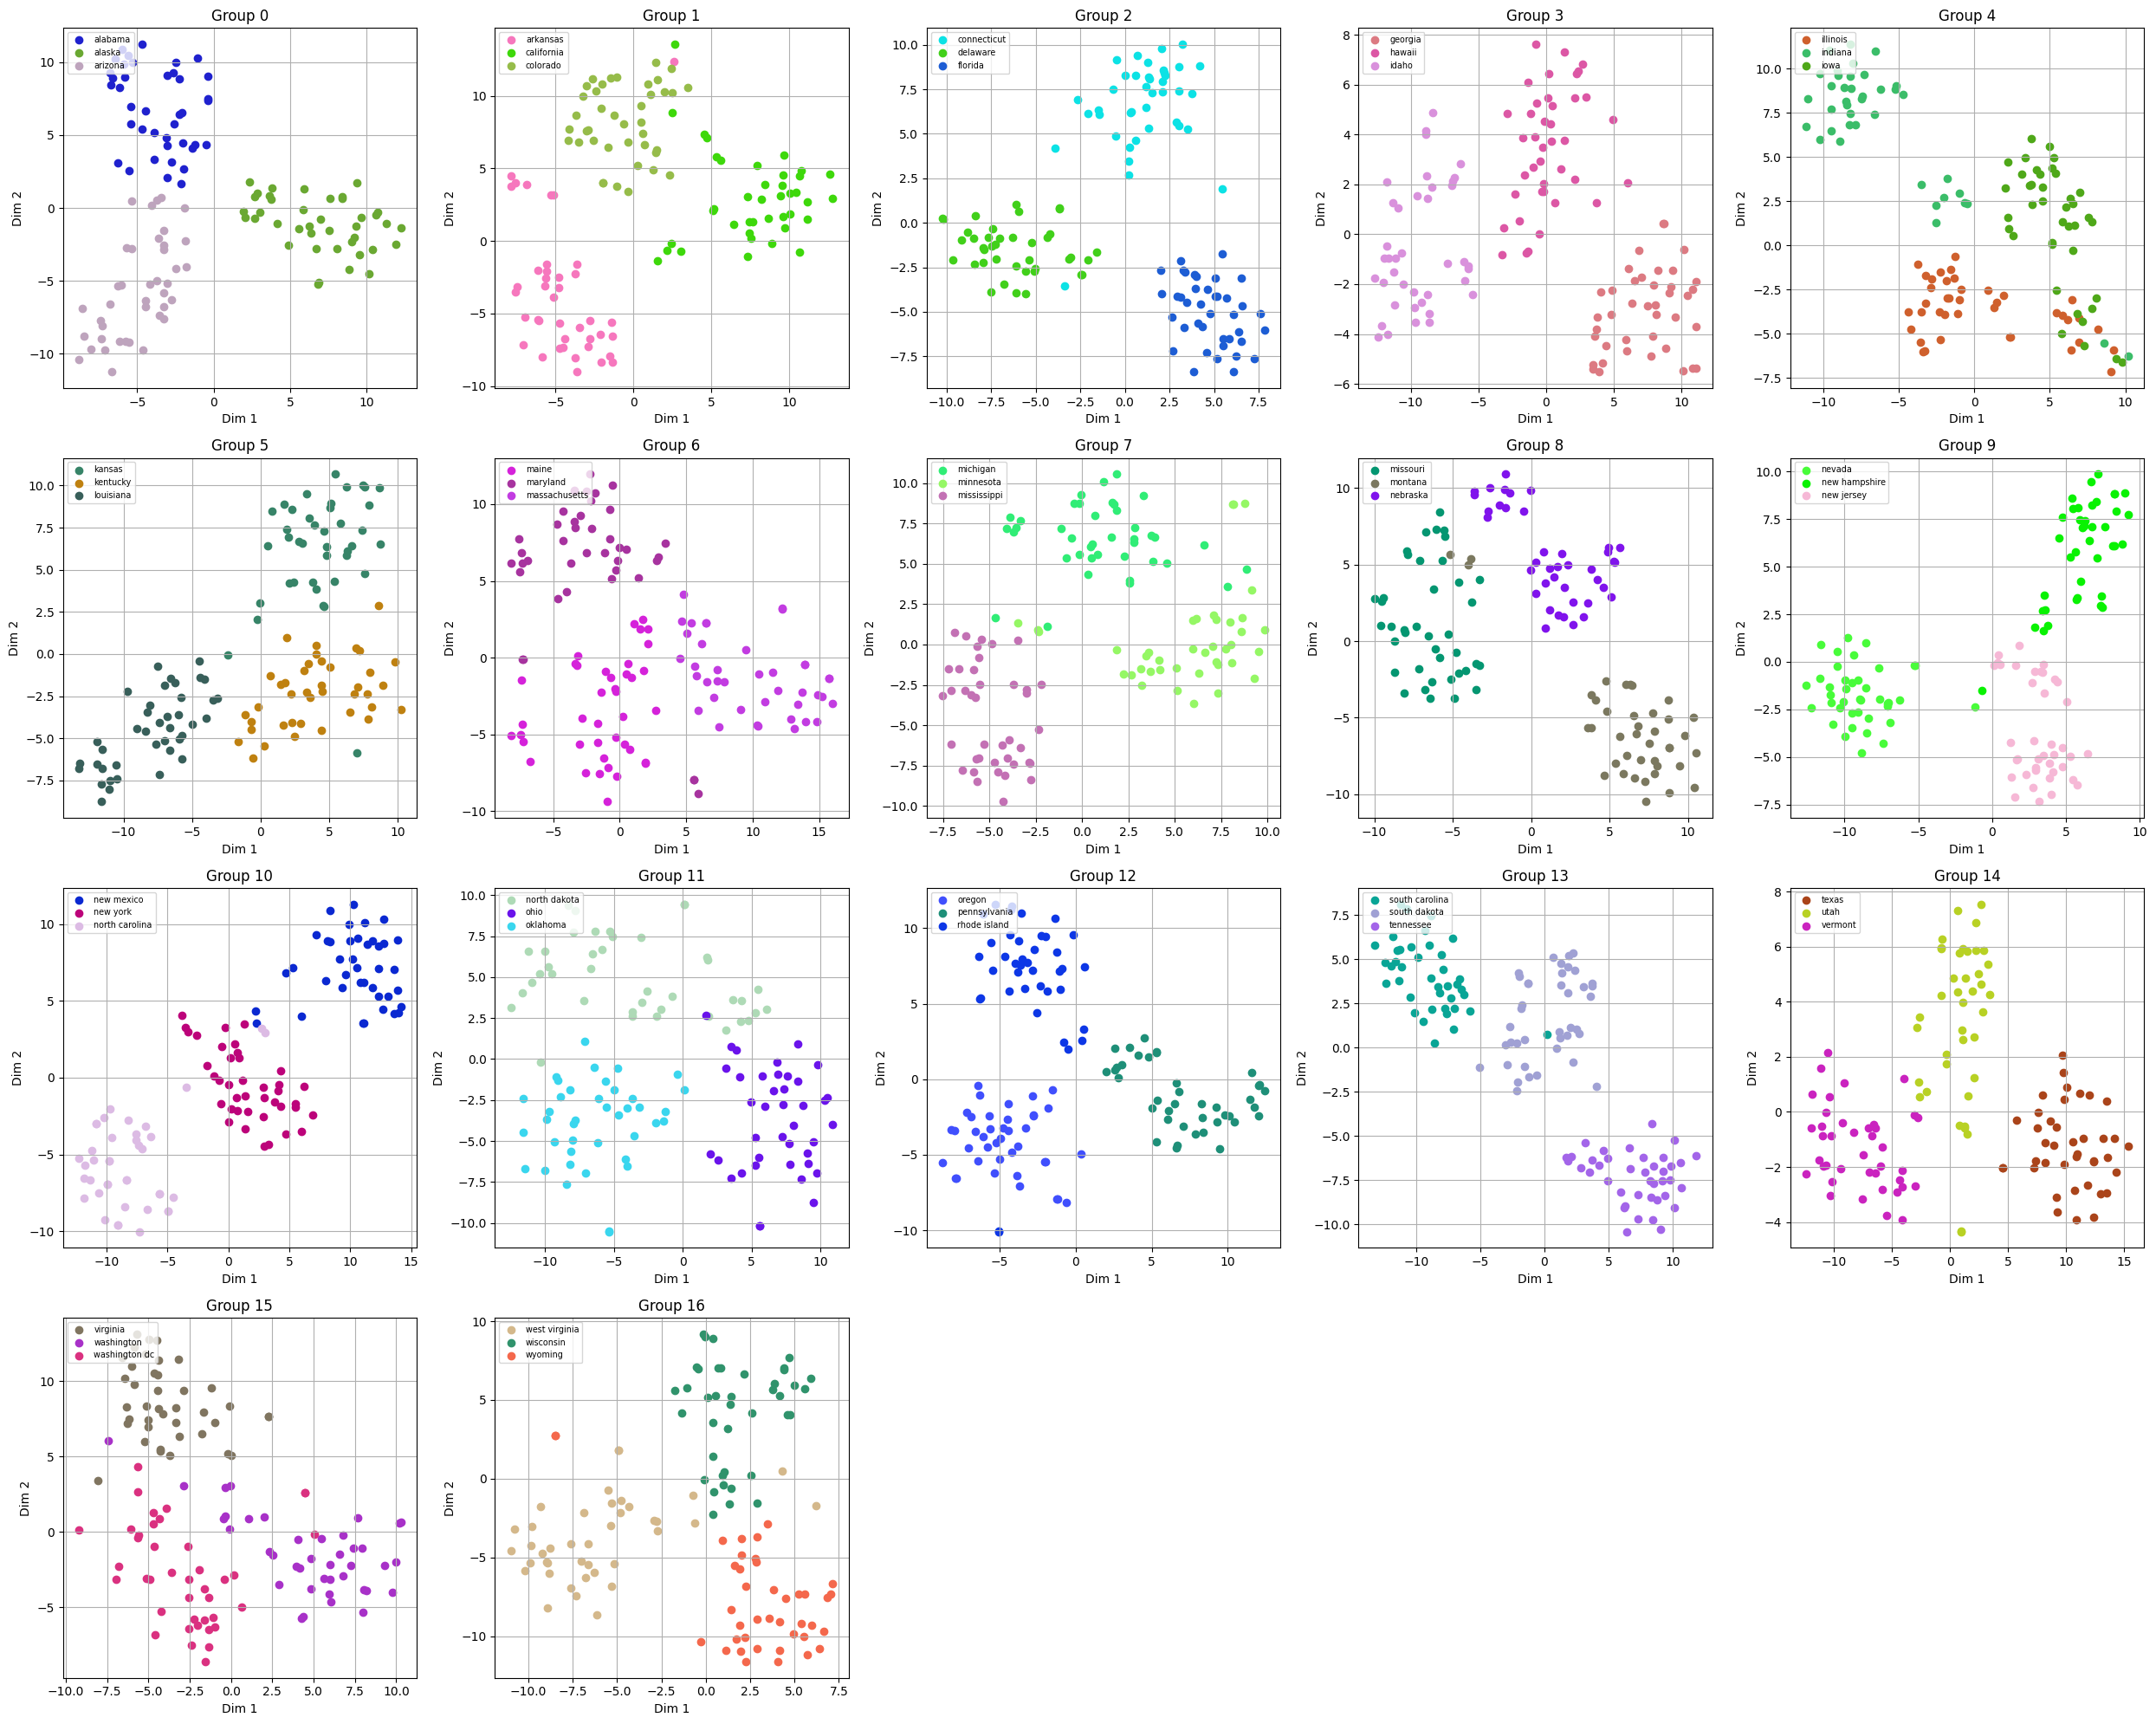

In [ ]:
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

# Generating a unique color map for 51 states
colors = ListedColormap(np.random.rand(51, 3))

fig = plt.figure(figsize=(25, 20))

for i in range(17):  # Loop through all groups
    emb = embeddings_data[i]
    concatenated_embeddings = np.array([sample['text_embedding'] + sample['image_embedding'] for sample in emb])

    # Create labels from 0 to 50 for the states
    labels = np.array([idx for idx in range(i*3, i*3 + 3) for _ in range(40)])

    # Shuffle the embeddings and labels together
    shuffled_embeddings, shuffled_labels = shuffle(concatenated_embeddings, labels, random_state=42)

    # Apply t-SNE on the concatenated embeddings array
    tsne = TSNE(n_components=2, random_state=0, perplexity=25)
    reduced_embeddings = tsne.fit_transform(shuffled_embeddings)

    # Create a subplot for each group in a 4x5 grid
    plt.subplot(4, 5, i+1)

    # Plot data points for each state in the group
    for j in range(i*3, i*3 + 3):
        if j < len(us_states):  # Ensure 'j' doesn't exceed the length of us_states
            mask = shuffled_labels == j
            plt.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], color=colors(j), label=us_states[j])

    plt.title(f"Group {i}")  # Title represents the group number
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(loc='upper left', fontsize='x-small')
    plt.grid(True)

plt.tight_layout()
plt.show()



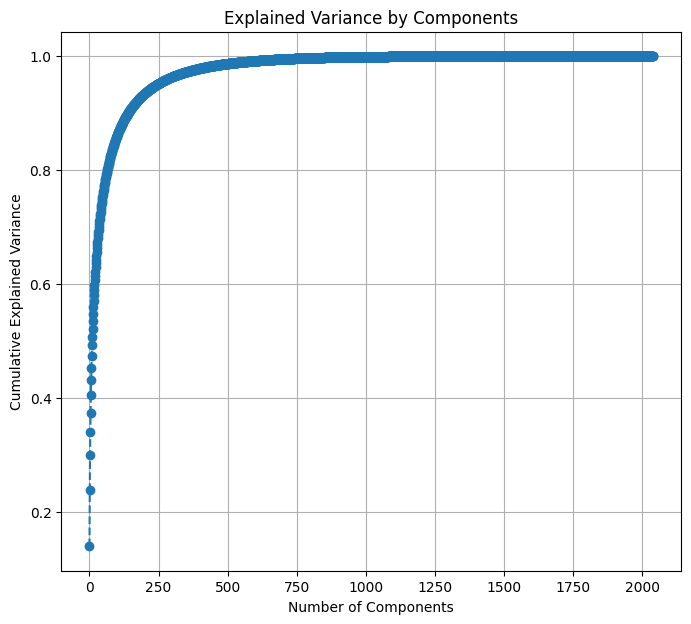

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Extracting all concatenated embeddings from the entire dataset
all_concatenated_embeddings = []
for group in embeddings_data:
    for state_data in group:
        concatenated = state_data['text_embedding'] + state_data['image_embedding']
        all_concatenated_embeddings.append(concatenated)

# Convert list to numpy array
concatenated_embeddings_array = np.array(all_concatenated_embeddings)

# 1. Standardize the data
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(concatenated_embeddings_array)

# 2. Apply PCA
pca = PCA()
principalComponents = pca.fit_transform(scaled_embeddings)

# 3. Visualize the results
# Plotting the explained variance for each principal component
plt.figure(figsize=(8, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


grouped_models = []

# Number of images per state
num_images_per_state = 40

# Iterate over the 17 groups
for group_idx, group in enumerate(embeddings_data):

    # Extract and concatenate embeddings for the three states within the group
    concatenated_embeddings = []
    for state_embedding in group:
        concatenated = state_embedding['text_embedding'] + state_embedding['image_embedding']
        concatenated_embeddings.append(concatenated)

    # Convert the list to a numpy array
    scaler = StandardScaler()
    group_embeddings = np.array(concatenated_embeddings)
    scaler.fit(group_embeddings)
    # Standardize the embeddings for the current group
    scaled_group_embeddings = scaler.transform(group_embeddings)
    # Extract the state names for the current group
    current_states = us_states[group_idx*3: (group_idx+1)*3]

    current_group_labels = []
    for i in range(3):  # As there are three states in each group
        current_group_labels.extend([i] * num_images_per_state)  # Add labels for each state

    # Split the group data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(scaled_group_embeddings, current_group_labels, test_size=0.3, random_state=42)

    # Train a Gradient Boosting classifier for the group
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, max_depth=3, random_state=42)
    clf.fit(X_train, y_train)

    # Validate the model
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred, average='macro')
    precision = precision_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f"Accuracy for Group {group_idx+1}: {accuracy:.4f}")
    print(f"Recall for Group {group_idx+1}: {recall:.4f}")
    print(f"Precision for Group {group_idx+1}: {precision:.4f}")
    print(f"F1 Score for Group {group_idx+1}: {f1:.4f} \n")

    grouped_models.append(clf)


Accuracy for Group 1: 0.8056
Recall for Group 1: 0.7984
Precision for Group 1: 0.8274
F1 Score for Group 1: 0.7974 

Accuracy for Group 2: 0.8333
Recall for Group 2: 0.8532
Precision for Group 2: 0.8611
F1 Score for Group 2: 0.8331 

Accuracy for Group 3: 0.8056
Recall for Group 3: 0.8214
Precision for Group 3: 0.8253
F1 Score for Group 3: 0.8061 

Accuracy for Group 4: 0.8333
Recall for Group 4: 0.8341
Precision for Group 4: 0.8341
F1 Score for Group 4: 0.8341 

Accuracy for Group 5: 0.8056
Recall for Group 5: 0.8024
Precision for Group 5: 0.8190
F1 Score for Group 5: 0.8082 

Accuracy for Group 6: 0.9167
Recall for Group 6: 0.9151
Precision for Group 6: 0.9156
F1 Score for Group 6: 0.9141 

Accuracy for Group 7: 0.9167
Recall for Group 7: 0.9095
Precision for Group 7: 0.9333
F1 Score for Group 7: 0.9136 

Accuracy for Group 8: 0.8889
Recall for Group 8: 0.9008
Precision for Group 8: 0.8932
F1 Score for Group 8: 0.8897 

Accuracy for Group 9: 0.8056
Recall for Group 9: 0.8040
Precisio

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Assuming you have the following variables defined from previous steps:
# - embeddings_data
# - states_sorted

grouped_models_knn = []

# Number of images per state
num_images_per_state = 40

# Iterate over the 17 groups
for group_idx, group in enumerate(embeddings_data):

    # Extract and concatenate embeddings for the three states within the group
    concatenated_embeddings = []
    for state_embedding in group:
        concatenated = state_embedding['text_embedding'] + state_embedding['image_embedding']
        concatenated_embeddings.append(concatenated)

    # Convert the list to a numpy array
    group_embeddings = np.array(concatenated_embeddings)
    # Extract the state names for the current group
    current_states = us_states[group_idx*3: (group_idx+1)*3]

    current_group_labels = []
    for i in range(3):  # As there are three states in each group
        current_group_labels.extend([i] * num_images_per_state)  # Add labels for each state

    # Ensure we have the same number of embeddings and labels
    assert len(group_embeddings) == len(current_group_labels), "Mismatch between number of embeddings and labels."

    # Split the group data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(group_embeddings, current_group_labels, test_size=0.3, random_state=42)

    # Train a KNN classifier for the group
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train, y_train)

    # Validate the model
    y_pred = knn_clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred, average='macro')
    precision = precision_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f"Accuracy for Group {group_idx+1}: {accuracy:.4f}")
    print(f"Recall for Group {group_idx+1}: {recall:.4f}")
    print(f"Precision for Group {group_idx+1}: {precision:.4f}")
    print(f"F1 Score for Group {group_idx+1}: {f1:.4f} \n")

    grouped_models_knn.append(knn_clf)


Accuracy for Group 1: 0.9722
Recall for Group 1: 0.9722
Precision for Group 1: 0.9697
F1 Score for Group 1: 0.9696 

Accuracy for Group 2: 0.8889
Recall for Group 2: 0.9008
Precision for Group 2: 0.9048
F1 Score for Group 2: 0.8900 

Accuracy for Group 3: 0.9444
Recall for Group 3: 0.9444
Precision for Group 3: 0.9475
F1 Score for Group 3: 0.9423 

Accuracy for Group 4: 1.0000
Recall for Group 4: 1.0000
Precision for Group 4: 1.0000
F1 Score for Group 4: 1.0000 

Accuracy for Group 5: 0.8611
Recall for Group 5: 0.8635
Precision for Group 5: 0.8625
F1 Score for Group 5: 0.8601 

Accuracy for Group 6: 0.9444
Recall for Group 6: 0.9484
Precision for Group 6: 0.9484
F1 Score for Group 6: 0.9484 

Accuracy for Group 7: 0.9722
Recall for Group 7: 0.9762
Precision for Group 7: 0.9744
F1 Score for Group 7: 0.9743 

Accuracy for Group 8: 1.0000
Recall for Group 8: 1.0000
Precision for Group 8: 1.0000
F1 Score for Group 8: 1.0000 

Accuracy for Group 9: 0.9722
Recall for Group 9: 0.9722
Precisio

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have the following variables defined from previous steps:
# - embeddings_data
# - states_sorted

grouped_models_rf = []

# Number of images per state
num_images_per_state = 40

# Iterate over the 17 groups
for group_idx, group in enumerate(embeddings_data):

    # Extract and concatenate embeddings for the three states within the group
    concatenated_embeddings = []
    for state_embedding in group:
        concatenated = state_embedding['text_embedding'] + state_embedding['image_embedding']
        concatenated_embeddings.append(concatenated)

    # Convert the list to a numpy array
    group_embeddings = np.array(concatenated_embeddings)

    # Extract the state names for the current group
    current_states = us_states[group_idx*3: (group_idx+1)*3]

    current_group_labels = []
    for i in range(3):  # As there are three states in each group
        current_group_labels.extend([i] * num_images_per_state)  # Add labels for each state

    # Ensure we have the same number of embeddings and labels
    assert len(group_embeddings) == len(current_group_labels), "Mismatch between number of embeddings and labels."

    # Split the group data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(group_embeddings, current_group_labels, test_size=0.3, random_state=42)

    # Train a Random Forest classifier for the group
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train, y_train)

    # Validate the model
    y_pred = rf_clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred, average='macro')
    precision = precision_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f"Accuracy for Group {group_idx+1}: {accuracy:.4f}")
    print(f"Recall for Group {group_idx+1}: {recall:.4f}")
    print(f"Precision for Group {group_idx+1}: {precision:.4f}")
    print(f"F1 Score for Group {group_idx+1}: {f1:.4f} \n")
    grouped_models_rf.append(rf_clf)


Accuracy for Group 1: 1.0000
Recall for Group 1: 1.0000
Precision for Group 1: 1.0000
F1 Score for Group 1: 1.0000 

Accuracy for Group 2: 0.9444
Recall for Group 2: 0.9484
Precision for Group 2: 0.9484
F1 Score for Group 2: 0.9484 

Accuracy for Group 3: 0.9444
Recall for Group 3: 0.9444
Precision for Group 3: 0.9475
F1 Score for Group 3: 0.9423 

Accuracy for Group 4: 0.9722
Recall for Group 4: 0.9762
Precision for Group 4: 0.9744
F1 Score for Group 4: 0.9743 

Accuracy for Group 5: 0.9444
Recall for Group 5: 0.9444
Precision for Group 5: 0.9444
F1 Score for Group 5: 0.9394 

Accuracy for Group 6: 0.9444
Recall for Group 6: 0.9484
Precision for Group 6: 0.9484
F1 Score for Group 6: 0.9484 

Accuracy for Group 7: 0.9722
Recall for Group 7: 0.9762
Precision for Group 7: 0.9744
F1 Score for Group 7: 0.9743 

Accuracy for Group 8: 1.0000
Recall for Group 8: 1.0000
Precision for Group 8: 1.0000
F1 Score for Group 8: 1.0000 

Accuracy for Group 9: 1.0000
Recall for Group 9: 1.0000
Precisio

In [ ]:
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# Define parameter grid for GradientBoostingClassifier (GBM)
param_grid_gbm = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, None],
    'subsample': [0.8, 0.9, 1]
}

# Define parameter grid for KNeighborsClassifier (KNN)
param_grid_knn = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Define parameter grid for RandomForestClassifier (RF)
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Define a function to perform grid search and return best model
def tune_hyperparameters(model, param_grid, X, y):
    grid_search = GridSearchCV(estimator=clone(model), param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(X, y)
    return grid_search.best_estimator_

# Tune RandomForest models
best_rf_models = []
for model in grouped_models_rf:
    best_rf = tune_hyperparameters(model, param_grid_rf, X_train, y_train)
    best_rf_models.append(best_rf)

# Now, let's move on to the KNN models
best_knn_models = []
for model in grouped_models_knn:
    best_knn = tune_hyperparameters(model, param_grid_knn, X_train, y_train)
    best_knn_models.append(best_knn)

# Finally, tune the GBM models
best_gbm_models = []
for model in grouped_models:
    best_gbm = tune_hyperparameters(model, param_grid_gbm, X_train, y_train)
    best_gbm_models.append(best_gbm)

In [ ]:
from sklearn.ensemble import VotingClassifier
ensemble_models = []

# Iterate over the 17 groups
for group_idx, group in enumerate(embeddings_data):

    # Extract and concatenate embeddings for the three states within the group
    concatenated_embeddings = []
    for state_embedding in group:
        concatenated = state_embedding['text_embedding'] + state_embedding['image_embedding']
        concatenated_embeddings.append(concatenated)

    # Convert the list to a numpy array
    group_embeddings = np.array(concatenated_embeddings)

    # Extract the state names for the current group
    current_states = us_states[group_idx*3: (group_idx+1)*3]

    current_group_labels = []
    for i in range(3):  # As there are three states in each group
        current_group_labels.extend([i] * num_images_per_state)  # Add labels for each state

    # Split the group data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(group_embeddings, current_group_labels, test_size=0.3, random_state=42)

    # Retrieve the models for the current group
    knn = best_knn_models[group_idx]
    lgbm_clf = best_gbm_models[group_idx]
    rf = best_rf_models[group_idx]

    # Fit individual models
    """knn.fit(X_train, y_train)
    lgbm_clf.fit(X_train, y_train)
    rf.fit(X_train, y_train)"""
    # Create an ensemble model for the current group
    ensemble = VotingClassifier(estimators=[('knn', knn), ('lgbm', lgbm_clf), ('rf', rf)], voting='soft')
    ensemble.fit(X_train, y_train)
    # For the ensemble, since it involves an LSTM, we'll only evaluate its performance (fitting it individually doesn't make sense as LSTM expects 3D input while others expect 2D)
    ensemble_y_pred = ensemble.predict(X_val)
    accuracy = accuracy_score(y_val, ensemble_y_pred)
    recall = recall_score(y_val, ensemble_y_pred, average='macro')
    precision = precision_score(y_val, ensemble_y_pred, average='macro')
    f1 = f1_score(y_val, ensemble_y_pred, average='macro')

    print(f"Accuracy for Group {group_idx+1}: {accuracy:.4f}")
    print(f"Recall for Group {group_idx+1}: {recall:.4f}")
    print(f"Precision for Group {group_idx+1}: {precision:.4f}")
    print(f"F1 Score for Group {group_idx+1}: {f1:.4f} \n")


    ensemble_models.append(ensemble)


Accuracy for Group 1: 1.0000
Recall for Group 1: 1.0000
Precision for Group 1: 1.0000
F1 Score for Group 1: 1.0000 

Accuracy for Group 2: 0.9444
Recall for Group 2: 0.9484
Precision for Group 2: 0.9444
F1 Score for Group 2: 0.9429 

Accuracy for Group 3: 0.9722
Recall for Group 3: 0.9722
Precision for Group 3: 0.9778
F1 Score for Group 3: 0.9740 

Accuracy for Group 4: 0.9167
Recall for Group 4: 0.9286
Precision for Group 4: 0.9221
F1 Score for Group 4: 0.9185 

Accuracy for Group 5: 0.8889
Recall for Group 5: 0.8929
Precision for Group 5: 0.9048
F1 Score for Group 5: 0.8845 

Accuracy for Group 6: 0.9722
Recall for Group 6: 0.9722
Precision for Group 6: 0.9697
F1 Score for Group 6: 0.9696 

Accuracy for Group 7: 1.0000
Recall for Group 7: 1.0000
Precision for Group 7: 1.0000
F1 Score for Group 7: 1.0000 

Accuracy for Group 8: 0.9722
Recall for Group 8: 0.9722
Precision for Group 8: 0.9778
F1 Score for Group 8: 0.9740 

Accuracy for Group 9: 0.9444
Recall for Group 9: 0.9444
Precisio

In [ ]:
def mega_ensemble_predict_proba(embedding, method="weighted"):
    """
    This function takes an embedding and uses the 17 ensemble models to predict the probability distribution over the states.
    Depending on the method specified, it uses either weighted averaging or thresholding.
    It then returns the state that has the highest probability according to the specified method.
    """
    # Convert embedding to numpy array if it's a list
    if isinstance(embedding, list):
        embedding = np.array(embedding)

    # Convert 1D embedding to 2D
    embedding_2d = embedding.reshape(1, -1)

    # Initialize an array to store the summed probabilities
    total_probabilities = np.zeros(51)  # For 51 states
    total_weights = np.zeros(51)  # For 51 states

    for ensemble_idx, ensemble in enumerate(ensemble_models):
        # Get predicted probabilities using the ensemble
        probabilities = ensemble.predict_proba(embedding_2d)

        # Map the probabilities of the 3 states to their respective positions in the 51-state array
        state_indices = list(range(ensemble_idx*3, (ensemble_idx+1)*3))

        for i, idx in enumerate(state_indices):
            if idx < 51:  # Ensure we're not indexing out of range
                total_probabilities[idx] += probabilities[0][i]
                total_weights[idx] += 1 if probabilities[0][i] > 0 else 0.1  # Assigning weights

    if method == "weighted":
        # Weighted averaging of the probabilities
        avg_probabilities = total_probabilities / total_weights
        return np.argmax(avg_probabilities)
    elif method == "threshold":
        # Return state if its total probability exceeds a threshold (e.g., 0.5)
        high_prob_states = np.where(total_probabilities > 0.5)[0]
        if len(high_prob_states) == 1:
            return high_prob_states[0]
        else:
            # If no state or multiple states exceed the threshold, return the state with highest total probability
            return np.argmax(total_probabilities)
    else:
        raise ValueError("Invalid method. Choose either 'weighted' or 'threshold'.")


In [ ]:
# Combine embeddings and labels from all groups
all_embeddings = []
all_labels = []

for group_idx, group in enumerate(embeddings_data):
    for state_idx, state_data in enumerate(group):
        concatenated = state_data['text_embedding'] + state_data['image_embedding']
        all_embeddings.append(concatenated)
        all_labels.append(group_idx * 3 + state_idx)  # Unique label for each state from 1 to 51

# Convert to numpy arrays
all_embeddings = np.array(all_embeddings)
all_labels = np.array(all_labels)

# Select samples
random_indices = np.random.choice(all_embeddings.shape[0], 75, replace=False)
selected_embeddings = all_embeddings[random_indices]

# Predict states using the mega ensemble
predicted_state_indices = [mega_ensemble_predict_proba(sample) for sample in selected_embeddings]
predicted_states = [us_states[index] for index in predicted_state_indices]

# Extract actual states for comparison
ceil = (random_indices / 120) * 3
ceil = np.floor(ceil).astype(int)
actual_states = [us_states[label] for label in (ceil)]

accuracy = accuracy_score(actual_states, predicted_states)



Accuracy Test Data - 97.33%
Recall Test Data - 97.92%
Precision Test Data - 97.92%
F1 Test Data - 97.33%



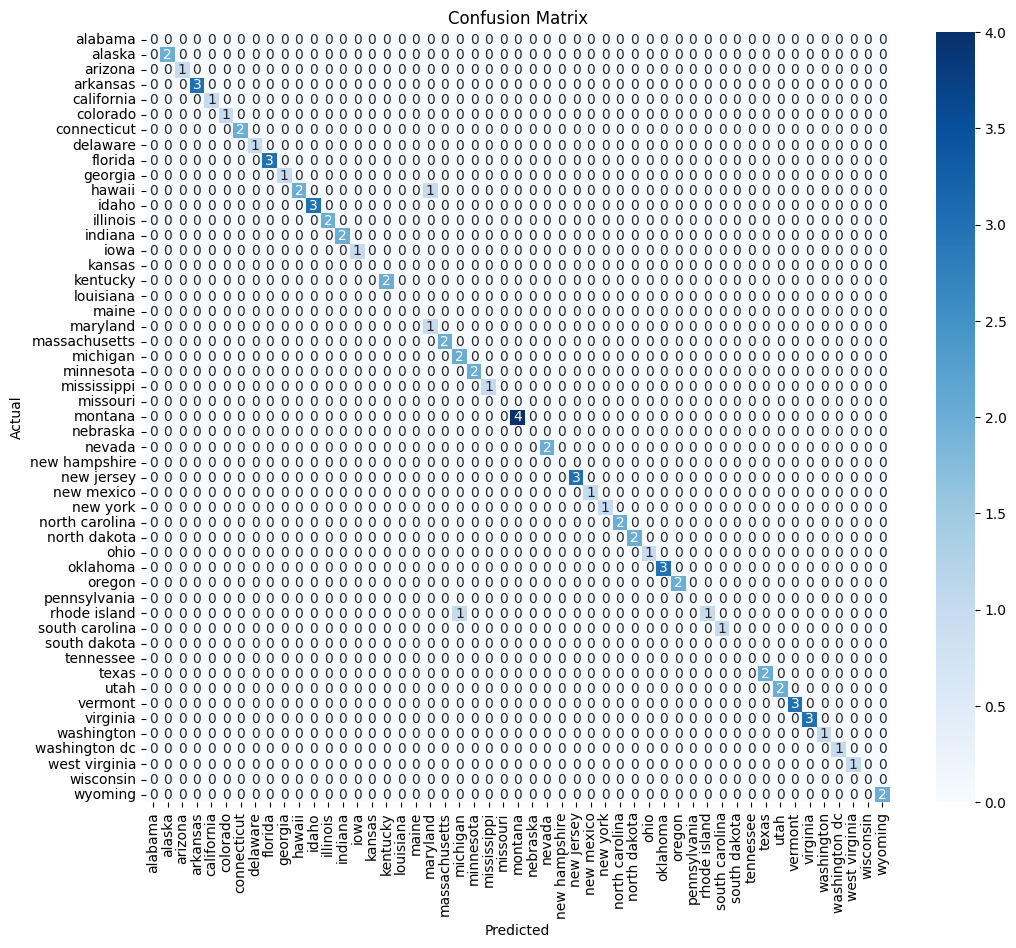

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Convert state names to numerical labels
label_mapping = {state: i for i, state in enumerate(us_states)}
actual_numeric_labels = [label_mapping[state] for state in actual_states]
predicted_numeric_labels = [label_mapping[state] for state in predicted_states]

# One-hot encoding of the labels
actual_onehot = label_binarize(actual_numeric_labels, classes=list(range(51)))
predicted_onehot = label_binarize(predicted_numeric_labels, classes=list(range(51)))


f1 = f1_score(actual_numeric_labels, predicted_numeric_labels, average='macro')
recall = recall_score(actual_numeric_labels, predicted_numeric_labels, average='macro', zero_division=0)
precision = precision_score(actual_numeric_labels, predicted_numeric_labels, average='macro', zero_division=0)

conf_matrix = confusion_matrix(actual_numeric_labels, predicted_numeric_labels)

print(f"Accuracy Test Data - {accuracy*100:.2f}%")
print(f"Recall Test Data - {recall*100:.2f}%")
print(f"Precision Test Data - {precision*100:.2f}%")
print(f"F1 Test Data - {f1*100:.2f}%\n")


# Calculate confusion matrix with fixed dimensions (based on number of states)
conf_matrix_fixed = confusion_matrix(actual_numeric_labels, predicted_numeric_labels, labels=np.arange(len(us_states)))

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_fixed, annot=True, fmt='g', cmap='Blues', xticklabels=us_states, yticklabels=us_states)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


